In [ ]:
! pip install cvxpy

In [1]:
import numpy as np
import cvxpy as cp

                                                                                
def motion_planner( obs_size=np.array([[10,7.5,2,4,10,3,2],[7.5, 10,2,15,1.5,12,4]]),
            obs_l=np.array([[-9.5, -9.5,-1.5,1,-1.5,5.5,6],[-9.5, -1,1,-7.5,8,-9.5,3]])): 
    
    '''
    Inputs:: 
    
    obs_size :   2 x n_obs dimensional array, describing the width and height of obstacles. n_obs= no. of obstacles
    obs_l    :   2 x n_obs dimensional array, describing the lower (south-western) corner of the obstacles

    Outputs::

    problem :    motion planning problem that can take starting position and goal position as parameters
    
    vars    :    variables for the motion planning problem = [state trajectory, input trajectory, binary variables for obstacle avoidance]

    params  :    parameters for the motion planning problem = [initial state, goal state]

    '''
    
    #  Obstacle "i" occupies the 2-dimensional interval:    [obs_l[:,i], obs_l[:,i]+obs_size[:,i]]
    n_obs=obs_size.shape[1]
    obs_u=obs_l+obs_size
    

    #### Dynamics model data ####
    # State of the robot at time t: x_t=[ X_t, Y_t, \dot{X}_t, \dot{Y}_t]   (position and speeds in X and Y coordinates)
    # control input at time t:      u_t=[\dot{\dot{X}}_t, \dot{\dot{Y}}_t], (accelerations in X and Y coordinates)
    # Robot dynamics equation:      x_{t+1}=Ax_t+Bu_t                       (derived by integrating the differential equations  [\dot{\dot{X}}}_t, \dot{\dot{Y}}_t]=u_t)       
    dt=0.2
    A = np.matrix([[1, 0, dt, 0],[0, 1, 0, dt],[0, 0, 1, 0],[0, 0, 0, 1]])
    B = dt*np.matrix([[0, 0],[0, 0],[1, 0],[0, 1]])

    nx = A.shape[1]#% Number of states
    nu = B.shape[1]#% Number of inputs

    #### MPC data ####
    # the cost function for the optimization problem is going to be 
    # \sum_{k=0}^{N} (||Q*x_k||+||R*u_k||)
    Q = 1000*np.identity(nx)
    R = 50*np.identity(nu)
    N = 100



    #### Robot constraints ####

    ## State constraints
    # The robot state is subject to lb_x <= x_t <= ub_x
    lb_x=np.array([-1,-5,-1,-1])    
    ub_x=np.array([20,5,1,1])     
    # robot must lie inside the rectangle with diagonally opposite points [-1,-5] and [20,5]
    # robot's speed must be within -1 to 1 m/s in both X and Y directions
   

    ## Control constraints
    # The robot's control (accleration) is subject to lb_u <= u_t <= ub_u
    lb_u=np.array([-2,-2])
    ub_u=-lb_u

 

    # Declaring variables for state and input trajectories
    x = cp.Variable((nx,N+1))    
    u = cp.Variable((nu,N))


    # Declare parameters
    x0   = cp.Parameter(nx)
    goal = cp.Parameter(nx) 



    # Declaring binary variables for obstacle avoidance formulation
    b_l=[cp.Variable((2,N),boolean=True) for _ in range(n_obs)]
    b_u=[cp.Variable((2,N),boolean=True) for _ in range(n_obs)]
    
    # big-M parameter
    M = np.diag([2*ub_x[0], 2*ub_x[1]])
    
    # Motion planning problem setup

    constraints = [x[:,0]==x0]   # initial condition constraint

    objective   = 0
    
    for k in range(N):
        constraints += [x[:,k+1]== A@x[:,k] + B@u[:,k]]    # adding dynamics constraints
          
        constraints+=[lb_x<=x[:,k+1],                      
                      ub_x>=x[:,k+1]]                      # adding state constraints
    
        constraints+=[lb_u<=u[:,k],
                      ub_u>=u[:,k]]                        # adding control constraints


        # big-M formulation of obstacle avoidance constraints  (DON'T WORRY ABOUT THIS FOR NOW, I WILL EXPLAIN!)
        for i in range (n_obs):
            constraints+=[x[0:2,k+1]<=obs_l[:,i]+M@b_l[i][:,k],
                          x[0:2,k+1]>=obs_u[:,i]-M@b_u[i][:,k], 
                          b_l[i][0,k]+b_l[i][1,k]+b_u[i][0,k]+b_u[i][1,k]<=2*2-1]       

        objective = objective + cp.norm(Q@(x[:,k]-goal),'inf') + cp.norm(R@u[:,k],'inf') # calculating cumulative cost
        
           
    
    objective = objective + 100*cp.norm(Q@(x[:,-1]-goal),'inf') # adding extreme penalty on terminal state to encourage getting close to the goal


    # Now, we define the problem
    problem = cp.Problem(cp.Minimize(objective), constraints)

    return problem, [x, u, b_l, b_u], [x0, goal]
  
    


(CVXPY) Sep 15 01:34:22 PM: Encountered unexpected exception importing solver GUROBI:
ImportError('libgurobi100.so: cannot open shared object file: No such file or directory')
(CVXPY) Sep 15 01:34:23 PM: Encountered unexpected exception importing solver GUROBI:
ImportError('libgurobi100.so: cannot open shared object file: No such file or directory')


In [2]:
## Construct the motion planning problem  

obs_size=np.array([[2.5, 2.5, 2.5, 1.7, 2],[2, 7, 2, 6.5, 8]])
obs_l=np.array([[-1, 2, 2, 5, 7],[1, -5, 3, -2, -5]])
n_obs=obs_size.shape[-1]

problem, vars, params = motion_planner(obs_size=obs_size, obs_l=obs_l)

x, u, b_l, b_u = vars
x0, goal       = params

In [3]:
## Instantiate the motion planning problem with an initial and goal condition
x0.value=   np.array([10.0, 0.0, 0.0, 0.0])
goal.value= np.array([0.,0.,0.,0.])


problem.solve(verbose=False)

print("Status: ",problem.status)
print("Optimal cost: ", problem.value)
print("Solve time (seconds): ", problem.solver_stats.solve_time)

# Finally, collect the optimized trajectory
x_sol=x.value
u_sol=u.value
b_l_sol=[b_l[i].value for i in range(n_obs)]
b_u_sol=[b_u[i].value for i in range(n_obs)]

Status:  optimal
Optimal cost:  378718.0270684
Solve time (seconds):  30.796274006000004


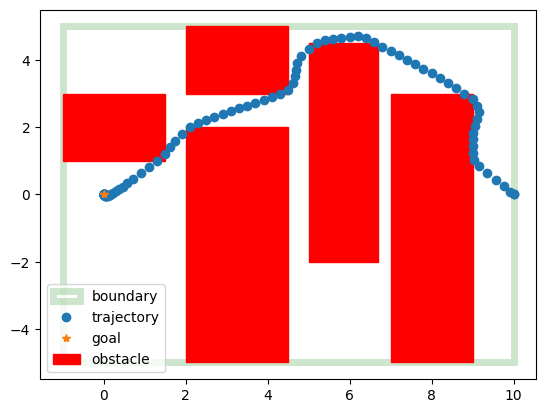

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline


fig=plt.figure()

plt.gca().add_patch(Rectangle((-1,-5),11,10, linewidth=5.0, ec='g', fc ='w', alpha=0.2, label="boundary"))
plt.plot(x_sol[0,:], x_sol[1,:],'o', label="trajectory")
plt.plot(0., 0., '*', linewidth=10, label="goal")
for i in range(n_obs):
    if i==0:
        plt.gca().add_patch(Rectangle((obs_l[0,i],obs_l[1,i]),obs_size[0,i],obs_size[1,i], ec='r', fc='r', label="obstacle"))
    else:
        plt.gca().add_patch(Rectangle((obs_l[0,i],obs_l[1,i]),obs_size[0,i],obs_size[1,i], ec='r', fc='r'))
plt.legend(loc=3)
plt.show()